In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta

import geopy.distance
pd.set_option('display.max_columns', None)


# AIR TRAVEL (March 2015-)

In [2]:
# ROOT_DIR = '/Users/alexanderguo/Desktop/flightlog/'
ROOT_DIR = '/Users/alexanderguo/Google Drive/MIT/junior/sem2/picrazy2.github.io/flightlog/'
df = pd.read_csv(ROOT_DIR + 'flightlog.csv')
airports = pd.read_csv(ROOT_DIR + 'airports.csv')

In [3]:
df['Date'] = pd.to_datetime(df['Date'])

df = df.merge(airports[['Name', 'City', 'Country', 'IATA', 'Lat', 'Long']], left_on='Dep Airport', right_on='IATA', how='left')
df = df.drop(columns='IATA').rename(columns={'Name': 'Dep Name', 'Lat': 'Dep Lat', 'Long': 'Dep Long', 'City': 'Dep City', 'Country': 'Dep Country'})
df = df.merge(airports[['Name', 'City', 'Country', 'IATA', 'Lat', 'Long']], left_on='Arr Airport', right_on='IATA', how='left')
df = df.drop(columns='IATA').rename(columns={'Name': 'Arr Name', 'Lat': 'Arr Lat', 'Long': 'Arr Long', 'City': 'Arr City', 'Country': 'Arr Country'})

df['Distance'] = df.apply(lambda row: geopy.distance.distance((row['Dep Lat'], row['Dep Long']), (row['Arr Lat'], row['Arr Long'])).miles, axis=1)
df['Duration'] = df.apply(lambda row: np.sum(np.multiply(np.array([int(x) for x in row['Actual Duration'].split(':')]), np.array([3600, 60, 1]))), axis=1)

important_cols = ['Date', 'Airline', 'Flight', 'Dep Airport', 'Arr Airport', 'Class', 'Aircraft', 'Actual Duration', 'Distance', 'Registration']

TOTAL_DIST = df['Distance'].sum()
TOTAL_TIME = df['Duration'].sum()
NUM_FLIGHTS = df['Date'].count()
NUM_AIRLINES = df['Airline'].nunique()
NUM_COUNTRIES = len(set(df['Dep Country'].tolist()) | set(df['Arr Country'].tolist()))
NUM_AIRPORTS = len(set(df['Dep Airport'].tolist()) | set(df['Arr Airport'].tolist()))

print('Total Distance Flown (miles): ' + str(TOTAL_DIST))
print('Total time in the air: ' + str(timedelta(seconds=int(TOTAL_TIME))))
print('Total Flights: ' + str(NUM_FLIGHTS))
print('Number of Airlines: ' + str(NUM_AIRLINES))
print('Number of Countries: ' + str(NUM_COUNTRIES))
print('Number of Airports: ' + str(NUM_AIRPORTS))

Total Distance Flown (miles): 380136.302226818
Total time in the air: 32 days, 2:13:48
Total Flights: 161
Number of Airlines: 26
Number of Countries: 21
Number of Airports: 60


# FLIGHTS SORTED BY DISTANCE

In [4]:
df.sort_values(['Distance'], ascending=False).head(50)[important_cols]
#loc[df['Domestic/International']=='Domestic']

,Date,Airline,Flight,Dep Airport,Arr Airport,Class,Aircraft,Actual Duration,Distance,Registration
71,2018-01-07,United,UA2,SIN,SFO,Business,B789,14:09:00,8446.305238,N38955
123,2019-12-18,United,UA1122,EWR,CPT,Business,B789,13:32:54,7816.760114,N27957
32,2017-01-02,United,UA840,SYD,LAX,Business,B789,13:07:53,7487.965805,N36962
74,2018-03-29,Hainan,HU7961,PVG,BOS,Economy,B789,14:00:33,7307.683803,B7835
73,2018-03-22,Hainan,HU7962,BOS,PVG,Economy,B788,15:57:00,7307.683803,B2750
82,2018-06-07,United,UA808,PEK,IAD,Economy,B788,12:44:00,6920.750901,N29907
61,2017-10-10,United,UA808,PEK,IAD,Economy,B772,13:10:19,6920.750901,N216UA
10,2016-01-02,United,UA808,PEK,IAD,Economy,B772,12:38:00,6920.750901,N222UA
95,2019-01-06,Air Canada,AC57,DXB,YYZ,Business,B77W,13:49:10,6899.002047,CFRAM
107,2019-06-09,United,UA88,PEK,EWR,Economy,B772,13:03:00,6830.922824,N77022


# FLIGHTS SORTED BY DURATION

In [5]:
df.sort_values(['Duration'], ascending=False).head(50)[important_cols]

,Date,Airline,Flight,Dep Airport,Arr Airport,Class,Aircraft,Actual Duration,Distance,Registration
73,2018-03-22,Hainan,HU7962,BOS,PVG,Economy,B788,15:57:00,7307.683803,B2750
71,2018-01-07,United,UA2,SIN,SFO,Business,B789,14:09:00,8446.305238,N38955
74,2018-03-29,Hainan,HU7961,PVG,BOS,Economy,B789,14:00:33,7307.683803,B7835
95,2019-01-06,Air Canada,AC57,DXB,YYZ,Business,B77W,13:49:10,6899.002047,CFRAM
123,2019-12-18,United,UA1122,EWR,CPT,Business,B789,13:32:54,7816.760114,N27957
20,2016-06-05,Hainan,HU482,BOS,PEK,Economy,B788,13:29:02,6736.622183,B2730
12,2016-03-13,Hainan,HU482,BOS,PEK,Business,B788,13:25:31,6736.622183,B2731
1,2015-03-08,United,UA89,EWR,PEK,Economy,B772,13:23:28,6830.922824,N78005
111,2019-08-17,United,UA89,EWR,PEK,Business,B772,13:22:00,6830.922824,N37018
69,2017-12-20,United,UA89,EWR,PEK,Business,B772,13:19:00,6830.922824,N74007


# ALL COUNTRIES AND AIRPORTS

In [6]:
dep_countries = df.groupby(['Dep Country', 'Dep Airport']).agg({'Date': 'count'}).reset_index()
dep_countries.columns = ['Country', 'Airport', 'Departures']
arr_countries = df.groupby(['Arr Country', 'Arr Airport']).agg({'Date': 'count'}).reset_index()
arr_countries.columns = ['Country', 'Airport', 'Arrivals']
countries = pd.merge(dep_countries, arr_countries, how='outer').fillna(0).groupby(['Country', 'Airport']).agg({'Departures': 'first', 'Arrivals': 'first'})
countries['Total Dep/Arr'] = countries['Departures'] + countries['Arrivals']
countries.astype('int32')

Departures  Arrivals  Total Dep/Arr
Country               Airport                                     
Australia             BNE               1         1              2
                      SYD               1         1              2
Bahamas               NAS               1         1              2
Bermuda               BDA               1         1              2
Canada                YYZ               1         1              2
China                 CTU               1         1              2
                      DNH               1         1              2
                      HRB               1         1              2
                      KJI               1         1              2
                      KMG               1         1              2
                      KWL               1         1              2
                      LHW               1         1              2
                      LJG               1         1              2
                      PEK              22        24             46
                      PVG               2         2              4
                      SHA               1         0              1
                      SYX               1         1              2
                      SZX               1         0              1
                      URC               2         2              4
                      WUX               1         1              2
                      XIY               1         1              2
France                CDG               2         2              4
                      NCE               1         1              2
Germany               FRA               1         1              2
                      MUC               1         1              2
Iceland               KEF               1         1              2
Japan                 HND               1         0              1
                      KIX               1         1              2
                      NRT               0         1              1
Malaysia              KUL               1         1              2
Portugal              LIS               1         1              2
Puerto Rico           SJU               1         1              2
Saint Kitts and Nevis SKB               1         1              2
Singapore             SIN               2         2              4
South Africa          CPT               2         1              3
                      PLZ               0         1              1
South Korea           GMP               1         1              2
                      ICN               1         1              2
Spain                 BCN               1         1              2
                      MAD               0         1              1
                      VLL               1         0              1
Thailand              BKK               0         1              1
                      DMK               1         0              1
United Arab Emirates  DXB               2         2              4
United Kingdom        LHR               1         1              2
United States         ANC               1         1              2
                      BDL               1         1              2
                      BOS              33        33             66
                      DEN               3         3              6
                      DTW               2         2              4
                      EWR              23        22             45
                      HNL               1         1              2
                      IAD               6         6             12
                      IAH               1         1              2
                      JFK               2         2              4
                      LAX               4         4              8
                      ORD               5         5             10
                      PHL               3         4              7
           

# AIRPORTS SORTED BY TOTAL DEPARTURES PLUS ARRIVALS

In [7]:
countries_sorted = countries.sort_values(by=['Total Dep/Arr'], ascending=False)
countries_sorted = countries_sorted.astype('int32')
countries_sorted.head(10)

Departures  Arrivals  Total Dep/Arr
Country       Airport                                     
United States BOS              33        33             66
China         PEK              22        24             46
United States EWR              23        22             45
              SFO               7         7             14
              IAD               6         6             12
              ORD               5         5             10
              LAX               4         4              8
              PHL               3         4              7
              DEN               3         3              6
Singapore     SIN               2         2              4

In [8]:
countries_sorted.reset_index().groupby('Country').agg({'Total Dep/Arr': sum}).sort_values(by='Total Dep/Arr', ascending=False).plot('Country', 'Total Dep/Arr', kind='pie', legend=False, figsize=(10, 10))

# TOP ROUTES

In [9]:
routes = df.groupby(['Dep Airport', 'Arr Airport']).agg({'Date': 'count', 'Distance': sum}).sort_values(by='Date', ascending=False)
routes.columns = ['Count', 'Total Distance']
routes.head(10)

Count  Total Distance
Dep Airport Arr Airport                       
BOS         EWR             13     2607.029351
EWR         BOS             10     2005.407193
            PEK             10    68309.228239
SFO         BOS              6    16224.706890
PEK         EWR              5    34154.614120
BOS         ORD              3     2599.949013
PEK         IAD              3    20762.252704
IAD         BOS              3     1238.508572
BOS         SFO              2     5408.235630
            PHL              2      560.040410

In [10]:
df['Sorted Route'] = df.apply(lambda row: str(sorted([row['Dep Airport'], row['Arr Airport']])[0]) + ' ' + str(sorted([row['Dep Airport'], row['Arr Airport']])[1]), axis=1)
routes_sorted = df.groupby('Sorted Route').agg({'Date': 'count', 'Distance': sum}).sort_values(by='Date', ascending=False)
routes_sorted.columns = ['Count', 'Total Distance']
routes_sorted.head(8)

,Count,Total Distance
Sorted Route,,
BOS EWR,23,4612.436543
EWR PEK,15,102463.842359
BOS SFO,8,21632.942519
BOS IAD,5,2064.180953
BOS ORD,4,3466.598684
BOS PHL,3,840.060616
BOS LAX,3,7833.396174
BOS DTW,3,1897.053119


# TOP AIRLINES

In [11]:
airlines = df.groupby(['Airline']).agg({'Date': 'count', 'Distance': sum}).sort_values(by='Date', ascending=False)
airlines.columns = ['Count', 'Total Distance']
airlines

,Count,Total Distance
Airline,,
United,88,246607.686900
Hainan,8,37281.869457
China Southern,7,5826.802274
JetBlue,6,9130.780630
Air China,5,6760.300960
American,5,4662.374153
China Eastern,5,4002.392049
Delta,5,2177.481006
Lufthansa,4,9568.892373


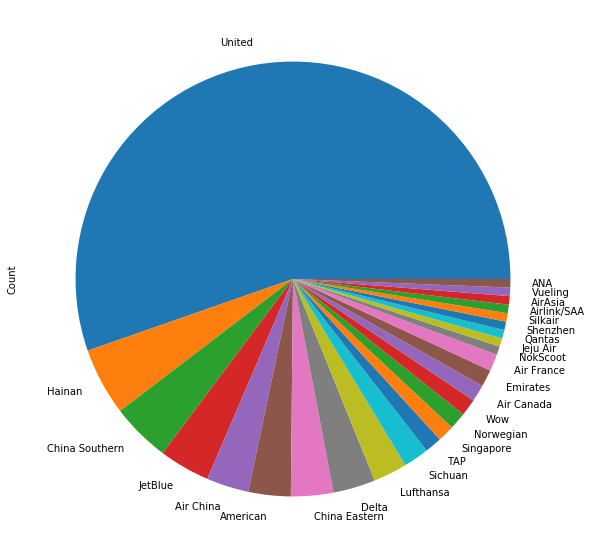

In [12]:
airlines.plot('Airline', 'Count', kind='pie', legend=False, figsize=(10, 10))

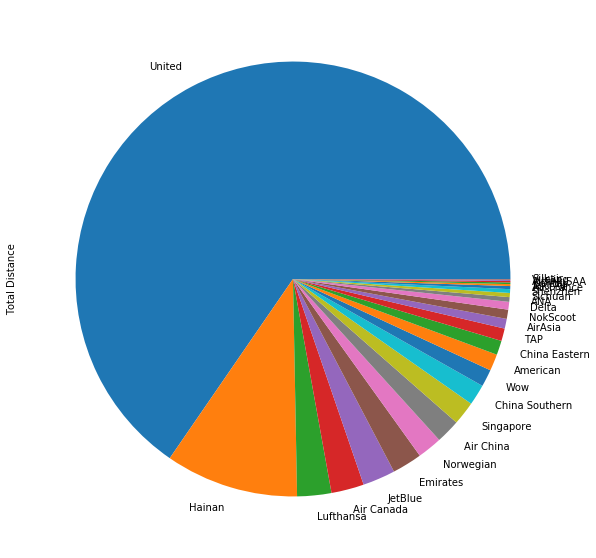

In [13]:
airlines.sort_values(by='Total Distance', ascending=False).plot('Airline', 'Total Distance', kind='pie', legend=False, figsize=(10, 10))

# TOP AIRCRAFT

In [14]:
aircraft = df.groupby(['Aircraft']).agg({'Date': 'count', 'Distance': sum}).sort_values(by='Date', ascending=False)
aircraft.columns = ['Count', 'Total Distance']
aircraft

,Count,Total Distance
Aircraft,,
B738,24,31715.880032
B772,21,131575.990384
A320,20,13473.833674
B739,14,7963.793973
B752,10,23438.453009
A321,9,12468.134146
B789,9,41579.305372
A319,7,3836.704959
B788,6,35741.114753


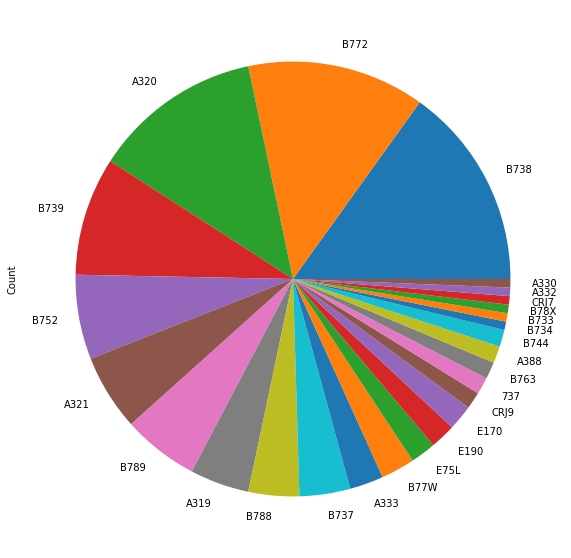

In [15]:
aircraft.plot('Aircraft', 'Count', kind='pie', legend=False, figsize=(10, 10))

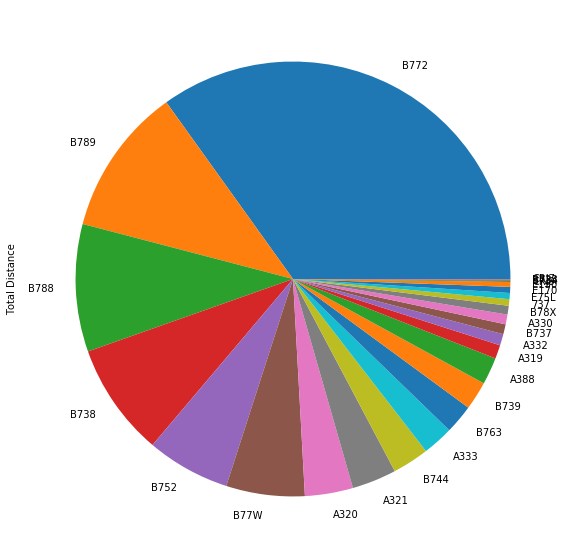

In [16]:
aircraft.sort_values(by='Total Distance', ascending=False).plot('Aircraft', 'Total Distance', kind='pie', legend=False, figsize=(10, 10))

# TOP AIRCRAFT REGS

In [17]:
reg = df.groupby(['Registration', 'Aircraft']).agg({'Date': 'count', 'Distance': sum}).sort_values(by='Date', ascending=False).head(10)
reg.columns = ['Count', 'Total Distance']
reg

,,Count,Total Distance
Registration,Aircraft,,
N78005,B772,3,20492.768472
N33284,B738,2,1954.588769
N19136,B752,2,5408.235630
B7880,B789,2,1364.555397
B2750,B788,2,14044.305986
N458UA,A320,2,846.738773
N78008,B772,2,13661.845648
N76010,B772,2,13661.845648
N67827,B739,1,200.540719


# TOP + ALL GATES (MISSING A LOT OF DATA)

In [18]:
df_orig = df.copy()
df_switch = df.copy()
df_orig = df_orig[df_orig['Dep Gate'].notna()]
df_switch = df_switch[df_switch['Arr Gate'].notna()]
df['Gate'] = df['Dep Airport'].astype(str) + ' ' + df['Dep Gate'].astype(str)
df_switch['Gate'] = df['Arr Airport'].astype(str) + ' ' + df['Arr Gate'].astype(str)
df_dup = pd.concat([df_orig, df_switch])
df_dup_grouped = df_dup.groupby(['Gate']).agg({'Date': 'count'}).sort_values(by='Date', ascending=False).head(40)
df_dup_grouped.columns = ['Count']
df_dup_grouped

/Users/alexanderguo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  import sys


,Count
Gate,
PEK E29,4
BOS B26,4
BOS B23,3
BOS B25,3
EWR B67,3
BOS B20,2
BOS B24,2
IAD C1,2
BOS B27,2


In [19]:
df_dup_grouped.reset_index().sort_values(by='Gate')

,Gate,Count
27,ANC B5,1
5,BOS B20,2
2,BOS B23,3
6,BOS B24,2
3,BOS B25,3
1,BOS B26,4
8,BOS B27,2
4,EWR B67,3
12,EWR C73,2
10,EWR C82,2


# TRAVEL BY YEAR

In [20]:
dist_year = df.groupby(df['Date'].dt.year).agg({'Distance': sum, 'Date': 'count'})
dist_year.columns = ['Distance', 'Flights']
dist_year

,Distance,Flights
Date,,
2015,29436.434579,10
2016,58570.729684,22
2017,78048.415226,39
2018,76497.985809,24
2019,84244.238494,32
2020,48040.013756,30
2021,5298.484679,4


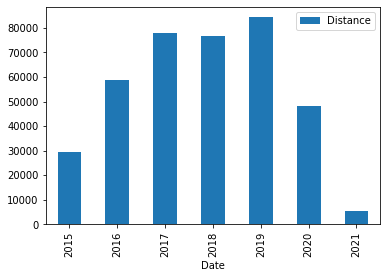

In [21]:
dist_year.reset_index().plot('Date', 'Distance', kind='bar')

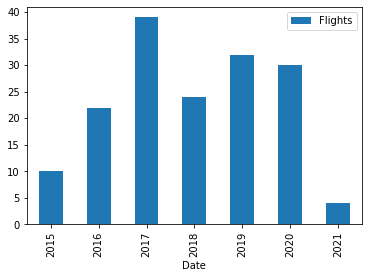

In [22]:
dist_year.reset_index().plot('Date', 'Flights', kind='bar')

# TRAVEL BY MONTH

In [23]:
df['Month'] = df['Date']
dist_yearm = df.groupby([df['Date'].dt.year, df['Month'].dt.month]).agg({'Distance': sum, 'Date': 'count'})
dist_yearm.columns = ['Distance', 'Flights']
dist_yearm.sort_values(by='Distance', ascending=False).head(30)

,,Distance,Flights
Date,Month,,
2019,12,20870.665731,7
2016,3,17481.756684,8
2018,3,17028.219491,3
2019,8,15448.226232,3
2020,1,14596.349780,8
2017,10,14365.050635,4
2016,12,14231.539360,6
2015,3,14062.927086,4
2017,3,14062.927086,4


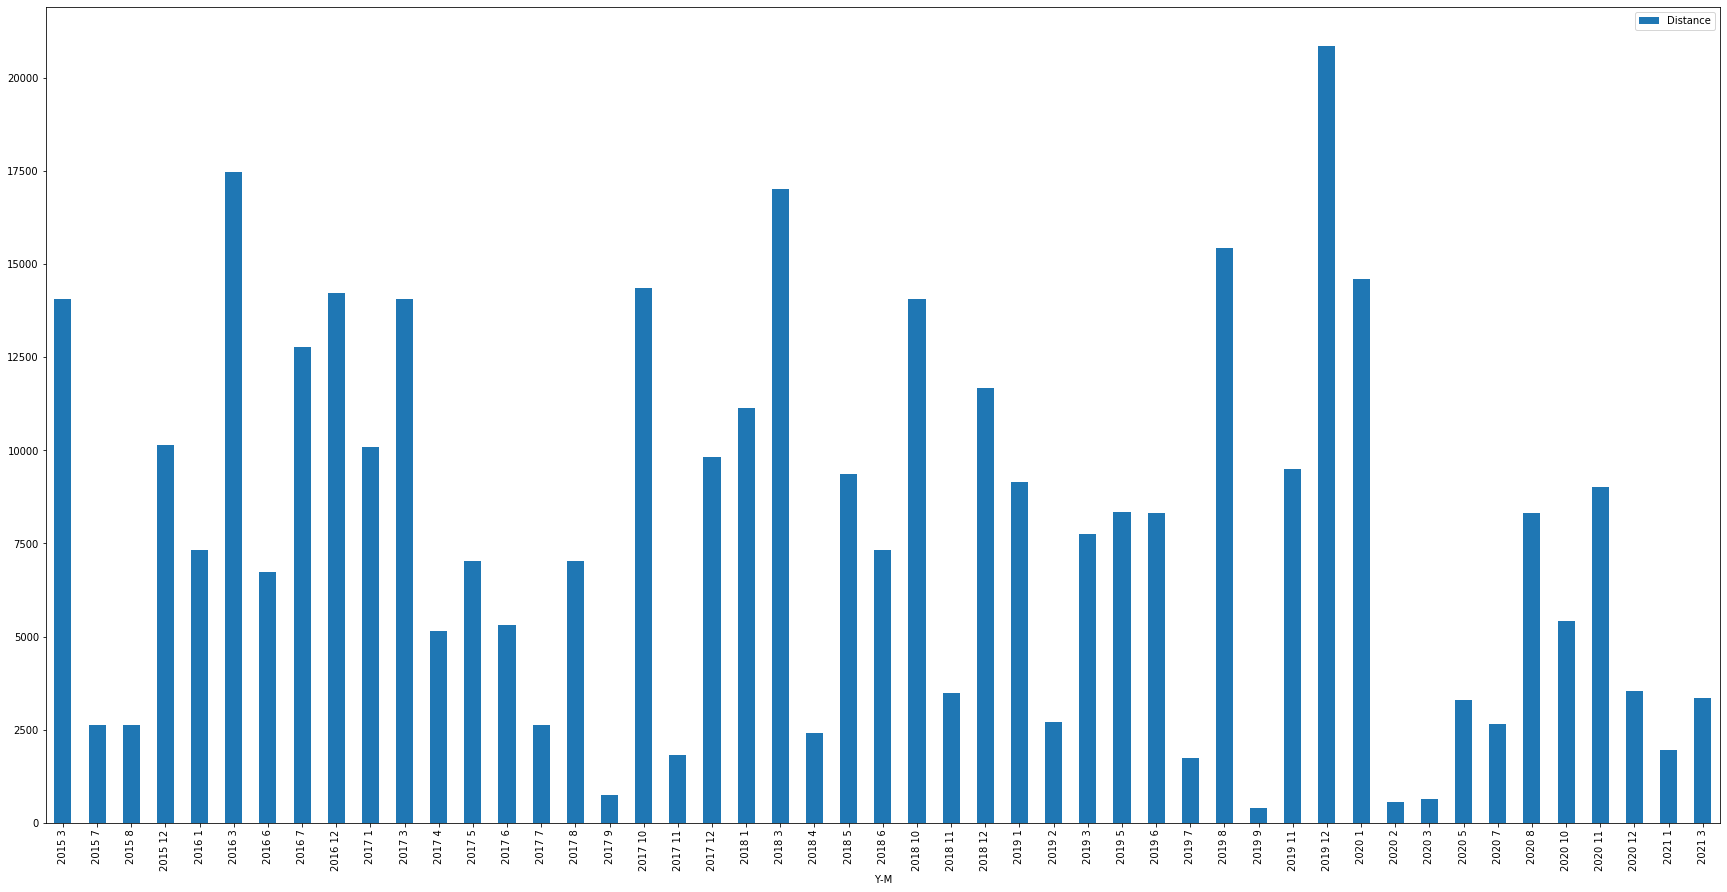

In [24]:
a = dist_yearm.reset_index()
a['Date'] = a['Date'].astype('int32')
a['Month'] = a['Month'].astype('int32')

a['Y-M'] = a['Date'].astype(str) + ' ' + a['Month'].astype(str)
a.plot('Y-M', 'Distance', kind='bar', figsize=(30, 15))

# DOMESTIC AND INTERNATIONAL BREAKDOWN

In [25]:
dom_int = df.groupby('Domestic/International').agg({'Distance': sum, 'Date': 'count'})
dom_int.columns = ['Distance', 'Flights']
dom_int

,Distance,Flights
Domestic/International,,
Domestic,100819.434856,101
International,279316.867371,60


In [26]:
print('Domestic average dist: ' + str(dom_int.loc['Domestic', 'Distance'] / dom_int.loc['Domestic', 'Flights']))
print('International average dist: ' + str(dom_int.loc['International', 'Distance'] / dom_int.loc['International', 'Flights']))

Domestic average dist: 998.2122263000116
International average dist: 4655.281122841944


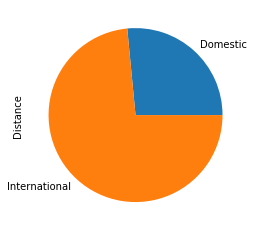

In [27]:
dom_int.plot('Domestic/International', 'Distance', kind='pie', legend=False)

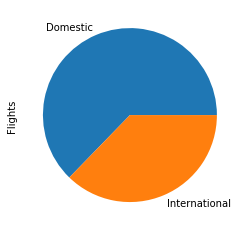

In [28]:
dom_int.plot('Domestic/International', 'Flights', kind='pie', legend=False)

In [29]:
year_dom_int = df.groupby([df['Date'].dt.year, 'Domestic/International']).agg({'Distance': sum, 'Date': 'count'})
year_dom_int.columns = ['Distance', 'Flights']
year_dom_int

Distance  Flights
Date Domestic/International                       
2015 Domestic                 8943.666107        7
     International           20492.768472        3
2016 Domestic                11296.768030       13
     International           47273.961655        9
2017 Domestic                18719.510846       28
     International           59328.904380       11
2018 Domestic                 5945.985799        9
     International           70552.000010       15
2019 Domestic                16722.896473       17
     International           67521.342021       15
2020 Domestic                35641.590777       24
     International           12398.422979        6
2021 Domestic                 3549.016823        3
     International            1749.467856        1

In [30]:
clas = df.groupby('Class').agg({'Distance': sum, 'Date': 'count'})
clas.columns = ['Distance', 'Flights']
clas

,Distance,Flights
Class,,
Business,133850.658666,44
Economy,242699.331642,114


# FARE CLASS BREAKDOWN

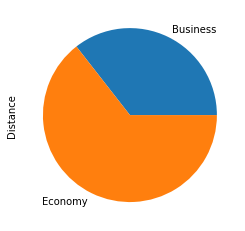

In [31]:
clas.plot('Class', 'Distance', kind='pie', legend=False)

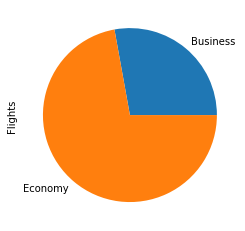

In [32]:
clas.plot('Class', 'Flights', kind='pie', legend=False)

In [33]:
year_clas = df.groupby([df['Date'].dt.year, 'Class']).agg({'Distance': sum, 'Date': 'count'})
year_clas.columns = ['Distance', 'Flights']
year_clas

Distance  Flights
Date Class                          
2015 Business    401.081439        2
     Economy   25915.573307        6
2016 Business  27053.538848        6
     Economy   31050.658750       15
2017 Business  26942.325389        7
     Economy   51106.089836       32
2018 Business  18262.603286        7
     Economy   58235.382522       17
2019 Business  38705.464773        9
     Economy   45538.773721       23
2020 Business  20535.636355       11
     Economy   27504.377401       19
2021 Business   1950.008575        2
     Economy    3348.476104        2


# CLASS AND TRIP TYPE BREAKDOWN

In [34]:
clas_dom_int = df.groupby(['Domestic/International', 'Class']).agg({'Distance': sum, 'Date': 'count'})
clas_dom_int.columns = ['Distance', 'Flights']
clas_dom_int

Distance  Flights
Domestic/International Class                           
Domestic               Business   22821.512251       22
                       Economy    74411.610686       76
International          Business  111029.146415       22
                       Economy   168287.720955       38

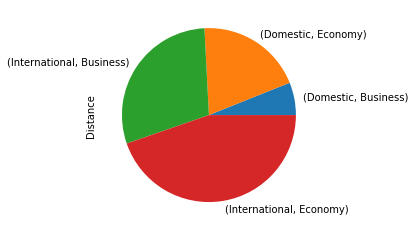

In [35]:
clas_dom_int.plot('Class', 'Distance', kind='pie', legend=False)

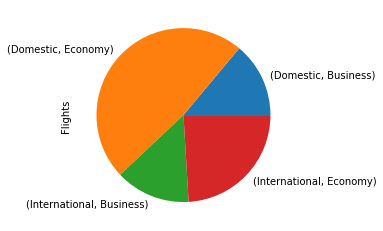

In [36]:
clas_dom_int.plot('Class', 'Flights', kind='pie', legend=False)

# ROUTES

In [37]:
import pyproj
from geojson import LineString, Feature, FeatureCollection, dump
import geopy.distance


def get_hist(x):
    dct = {a: x.tolist().count(a) for a in x.tolist()}
    return ';'.join([str(list(dct.keys())[i]) + ',' + str(list(dct.values())[i]) for i in range(len(dct))])


def augment_routes(df):
    route_grouped = df.groupby('Sorted Route')
    df[['Class', 'Airline', 'Flight']] = df[['Class', 'Airline', 'Flight']].fillna('Unknown')
    df['route_date_string'] = route_grouped['Date'].transform(lambda x: ';'.join(str(a) for a in x))
    df['route_class_hist'] = route_grouped['Class'].transform(get_hist)#(lambda x: str(x.tolist().count('Economy')) + ',' + str(x.tolist().count('Business')))
    df['route_airline_hist'] = route_grouped['Airline'].transform(get_hist)
    df['route_flight_string'] = route_grouped['Flight'].transform(lambda x: ';'.join(x))
    df['route_origin_hist'] = route_grouped['Dep Airport'].transform(get_hist)
    grouped = df.groupby('Sorted Route').first()[['Distance', 'Duration', 'Domestic/International',
                                        'route_date_string', 'route_class_hist', 'route_airline_hist', 'route_flight_string', 'route_origin_hist'
                                       ]]
    grouped['count'] = grouped['route_date_string'].apply(lambda x: len(x.split(';')))

    grouped = grouped.reset_index()
    grouped['Dep IATA'] = grouped['Sorted Route'].apply(lambda x: x.split(' ')[0])
    grouped['Arr IATA'] = grouped['Sorted Route'].apply(lambda x: x.split(' ')[1])
    grouped = grouped.merge(airports[['IATA', 'Name', 'City', 'Country', 'Lat', 'Long']], left_on='Dep IATA', right_on='IATA', how='left')
    grouped = grouped.drop(columns='IATA').rename(columns={'Name': 'Dep Name', 'City': 'Dep City', 'Country': 'Dep Country', 'Lat': 'Dep Lat', 'Long': 'Dep Long'})
    grouped = grouped.merge(airports[['IATA', 'Name', 'City', 'Country', 'Lat', 'Long']], left_on='Arr IATA', right_on='IATA', how='left')
    grouped = grouped.drop(columns='IATA').rename(columns={'Name': 'Arr Name', 'City': 'Arr City', 'Country': 'Arr Country', 'Lat': 'Arr Lat', 'Long': 'Arr Long'})

    return grouped




def get_path(startlong, startlat, endlong, endlat):
    # calculate distance between points
    g = pyproj.Geod(ellps='WGS84')
    (az12, az21, dist) = g.inv(startlong, startlat, endlong, endlat)

    # calculate line string along path with segments <= 1 km
    lonlats = g.npts(startlong, startlat, endlong, endlat,
                     1 + int(dist / 5000))
    
    # npts doesn't include start/end points, so prepend/append them
    lonlats.insert(0, (startlong, startlat))
    lonlats.append((endlong, endlat))
    offset = 0
    for i in range(len(lonlats)-1):
        if lonlats[i][0] > 0 and lonlats[i+1][0] < 0 and lonlats[i+1][0] < -170:
            offset = 360
        elif lonlats[i][0] < 0 and lonlats[i+1][0] > 0 and lonlats[i+1][0] > 170:
            offset = -360
        lonlats[i+1] = (lonlats[i+1][0] + offset , lonlats[i+1][1])
#     print(len(lonlats))
    return LineString(lonlats)


def make_route_geojson(df, path):
    
    grouped = augment_routes(df)
    
    features = []
    for i, row in grouped.iterrows():
    #     lats = row['Sorted Lat'].split(';')
    #     longs = row['Sorted Long'].split(';')
        properties = properties = {'start_iata': row['Dep IATA'], 
                              'start_name': row['Dep Name'], 
                              'start_city_country': row['Dep City'] + ', ' + row['Dep Country'], 
                              'end_iata': row['Arr IATA'], 
                              'end_name': row['Arr Name'], 
                              'end_city_country': row['Arr City'] + ', ' + row['Arr Country'],  
                              'dist': row['Distance'], 
                              'dur': row['Duration'],
                              'domint': row['Domestic/International'],
                              'count': row['count'],
                              'earliest_date': row['route_date_string'].split(';')[0].split(' ')[0],
                              'latest_date': row['route_date_string'].split(';')[-1].split(' ')[0],
                              'date_string': row['route_date_string'],
                              'class_hist': row['route_class_hist'],
                              'airline_hist': row['route_airline_hist'],
                              'flight_string': row['route_flight_string'],
                              'origin_hist': row['route_origin_hist']
                             }
        features.append(Feature(geometry=get_path(row['Dep Long'], row['Dep Lat'], 
                                                  row['Arr Long'], row['Arr Lat']),
                                properties = properties))
    fc = FeatureCollection(features)

    with open(path, 'w') as f:
        dump(fc, f)



# AIRPORTS AUGMENTED

In [38]:
from geojson import Point, Feature, FeatureCollection, dump

def augment_airports(df):
    df['Year'] = df['Date'].dt.year

    dep_grouped = df.groupby('Dep Airport')
    df['dep_dest_hist'] = dep_grouped['Arr Airport'].transform(get_hist)
    df['dep_count'] = dep_grouped['Date'].transform(lambda v: v.shape[0])
    df['dep_first'] = dep_grouped['Date'].transform(lambda v: min(v))
    df['dep_last'] = dep_grouped['Date'].transform(lambda v: max(v))
    df['dep_airline_hist'] = dep_grouped['Airline'].transform(get_hist)
    df['dep_intdom_hist'] = dep_grouped['Domestic/International'].transform(get_hist)
    df['dep_year_hist'] = dep_grouped['Year'].transform(get_hist)

    arr_grouped = df.groupby('Arr Airport')
    df['arr_dest_hist'] = arr_grouped['Dep Airport'].transform(get_hist)
    df['arr_count'] = arr_grouped['Date'].transform(lambda v: v.shape[0])
    df['arr_first'] = arr_grouped['Date'].transform(lambda v: min(v))
    df['arr_last'] = arr_grouped['Date'].transform(lambda v: max(v))
    df['arr_conn_count'] = arr_grouped['Arr Connect'].transform(lambda v: int(v.sum())).astype('int')
    df['arr_airline_hist'] = arr_grouped['Airline'].transform(get_hist)
    df['arr_intdom_hist'] = arr_grouped['Domestic/International'].transform(get_hist)
    df['arr_year_hist'] = arr_grouped['Year'].transform(get_hist)

    df['arr_conn_year_hist'] = df[df['Arr Connect'] == 1].groupby('Arr Airport')['Year'].transform(get_hist)

    df = df.drop(columns='arr_conn_year_hist').merge(df[['Arr Airport', 'arr_conn_year_hist']].dropna().drop_duplicates(), on='Arr Airport', how='left')

    deps = df.groupby('Dep Airport').first()[['Dep Name', 'Dep City', 'Dep Country', 'Dep Lat', 'Dep Long',
                                       'dep_dest_hist', 'dep_count', 'dep_first', 'dep_last', 'dep_airline_hist', 'dep_intdom_hist', 'dep_year_hist'
                                      ]].reset_index()
    arrcons = df.groupby('Arr Airport').first()[['Arr Name', 'Arr City', 'Arr Country', 'Arr Lat', 'Arr Long',
                                                 'arr_dest_hist', 'arr_count', 'arr_first', 'arr_last', 'arr_airline_hist', 'arr_intdom_hist', 'arr_year_hist',
                                       'arr_conn_count', 'arr_conn_year_hist'
                                      ]].reset_index()
    airports_aug = deps.merge(arrcons, left_on='Dep Airport', right_on='Arr Airport', how='outer')
    
    def merge_names(row):
        for col in ['Airport', 'Name', 'City', 'Country']:
            row[col] = row['Dep '+ col] if type(row['Dep '+ col]) == str else row['Arr '+ col]
        for col in ['Lat', 'Long']:
            row[col] = row['Dep '+ col] if not np.isnan(row['Dep '+ col]) else row['Arr '+ col]
        return row


    airports_aug = airports_aug.apply(merge_names, axis=1)
    airports_aug = airports_aug.rename(columns={'Airport': 'IATA'})

    airports_aug = airports_aug[['IATA', 'Name', 'City', 'Country', 'Lat', 'Long',
                                 'dep_count', 'arr_count', 'arr_conn_count',
                                 'dep_dest_hist', 'arr_dest_hist',
                                 'dep_first', 'arr_first', 'dep_last', 'arr_last',
                                 'dep_airline_hist', 'arr_airline_hist',
                                 'dep_intdom_hist', 'arr_intdom_hist',
                                 'dep_year_hist', 'arr_year_hist', 'arr_conn_year_hist'
                                ]]
    airports_aug['dep_count'] = airports_aug['dep_count'].fillna(0) - airports_aug['arr_conn_count'].fillna(0)
    airports_aug['arr_count'] = airports_aug['arr_count'].fillna(0) - airports_aug['arr_conn_count'].fillna(0)

    def subtract_hist(row):
        dep_hist = {int(x.split(',')[0]): int(x.split(',')[1]) for x in row['dep_year_hist'].split(';')} if row['dep_year_hist'] != '' else {}
        arr_hist = {int(x.split(',')[0]): int(x.split(',')[1]) for x in row['arr_year_hist'].split(';')} if row['arr_year_hist'] != '' else {}
        conn_hist = {int(x.split(',')[0]): int(x.split(',')[1]) for x in row['arr_conn_year_hist'].split(';')} if row['arr_conn_year_hist'] != '' else {}

        for year in conn_hist:
            if year in dep_hist:
                dep_hist[year] -= conn_hist[year]
            else:
                print(year, 'not in dep')
            if year in arr_hist:
                arr_hist[year] -= conn_hist[year]
            else:
                print(year, 'not in arr')

        row['dep_year_hist'] = ';'.join([str(x) + ',' + str(dep_hist[x]) for x in dep_hist if dep_hist[x] > 0])
        row['arr_year_hist'] = ';'.join([str(x) + ',' + str(arr_hist[x]) for x in arr_hist if arr_hist[x] > 0])
        full_year_hist = {}
        for key in dep_hist:
            full_year_hist[key] = full_year_hist[key] + dep_hist[key] if key in full_year_hist else dep_hist[key]
        for key in arr_hist:
            full_year_hist[key] = full_year_hist[key] + arr_hist[key] if key in full_year_hist else arr_hist[key]
        for key in conn_hist:
            full_year_hist[key] = full_year_hist[key] + conn_hist[key] if key in full_year_hist else conn_hist[key]
        row['full_year_hist'] = ';'.join([str(x) + ',' + str(full_year_hist[x]) for x in full_year_hist if full_year_hist[x] > 0])
        return row

    airports_aug[['dep_year_hist', 'arr_year_hist', 'arr_conn_year_hist']] = airports_aug[['dep_year_hist', 'arr_year_hist', 'arr_conn_year_hist']].fillna('')
    airports_aug = airports_aug.apply(subtract_hist, axis=1)
    airports_aug['total'] = airports_aug['dep_count'].fillna(0) + airports_aug['arr_count'].fillna(0) + airports_aug['arr_conn_count'].fillna(0)
    airports_aug['first'] = airports_aug.apply(lambda row: min(row['dep_first'], row['arr_first']), axis=1)
    airports_aug['last'] = airports_aug.apply(lambda row: min(row['dep_last'], row['arr_last']), axis=1)
    year_airports_aug.append(airports_aug)
    return airports_aug

def make_airport_geojson(df, path):
    airports_aug = augment_airports(df)
    for col in ['dep_first', 'arr_first', 'dep_last', 'arr_last', 'first', 'last']:
        airports_aug[col] = airports_aug[col].dt.strftime('%Y-%m-%d')
    airports_aug = airports_aug.fillna('')
    features = []
    for i, row in airports_aug.iterrows():
#         print(row.drop(['Lat', 'Long']).to_dict())
        features.append(Feature(geometry=Point((row['Long'], row['Lat'])), properties=row.drop(['Lat', 'Long']).to_dict()))
    fc = FeatureCollection(features)
    with open(path, 'w') as f:
        dump(fc, f)


In [39]:
#### MAKE ROUTES
year_airports_aug = [] # first one is all

make_route_geojson(df, ROOT_DIR + 'routes_all.geojson')
make_airport_geojson(df, ROOT_DIR + 'airports_all.geojson')

all_years = df['Date'].dt.year.unique().tolist()
first_month = min(df[df['Date'].dt.year == all_years[0]]['Date'].dt.month)
last_month = max(df[df['Date'].dt.year == all_years[-1]]['Date'].dt.month)

with open(ROOT_DIR + "month_range.txt", "w") as text_file:
    text_file.write(','.join(str(x) for x in all_years) + '\n' + str(first_month) + ',' + str(last_month))

for year in all_years:
    make_route_geojson(df[df['Date'].dt.year == year], ROOT_DIR + 'routes_' + str(year) + '.geojson')
    make_airport_geojson(df[df['Date'].dt.year == year], ROOT_DIR + 'airports_' + str(year) + '.geojson')

print('years done')

for year in all_years:
    print(year)
    for month in range(1, 13):
        if year == all_years[0] and month < first_month:
            continue
        if year == all_years[-1] and month > last_month:
            continue
        print('  ', month)
        simp_df = pd.concat([df[df['Date'].dt.year < year], df[df['Date'].dt.year == year][df['Date'].dt.month <= month]], ignore_index=True)
        make_route_geojson(simp_df, ROOT_DIR + 'routes_cum_' + str(year) + '_' + str(month) + '.geojson')
        make_airport_geojson(simp_df, ROOT_DIR + 'airports_cum_' + str(year) + '_' + str(month) + '.geojson')
    


/Users/alexanderguo/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/Users/alexanderguo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/alexanderguo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

years done
2015
   3
   4


/Users/alexanderguo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


   5
   6
   7
   8
   9
   10
   11
   12
2016
   1
   2
   3
   4
   5
   6
   7
   8
   9
   10
   11
   12
2017
   1
   2
   3
   4
   5
   6
   7
   8
   9
   10
   11
   12
2018
   1
   2
   3
   4
   5
   6
   7
   8
   9
   10
   11
   12
2019
   1
   2
   3
   4
   5
   6
   7
   8
   9
   10
   11
   12
2020
   1
   2
   3
   4
   5
   6
   7
   8
   9
   10
   11
2020 not in dep
   12
2021
   1
   2
   3


# PRINTING

In [40]:
def get_stats(df, airports_aug, year=None, a=False):
    TOTAL_DIST = df['Distance'].sum()
    NUM_FLIGHTS = df['Date'].count()
    NUM_AIRLINES = df['Airline'].nunique()
    NUM_COUNTRIES = len(set(df['Dep Country'].tolist()) | set(df['Arr Country'].tolist()))
    NUM_AIRPORTS = len(set(df['Dep Airport'].tolist()) | set(df['Arr Airport'].tolist()))

    dep_countries = df.groupby(['Dep Country', 'Dep Airport']).agg({'Date': 'count'}).reset_index()
    dep_countries.columns = ['Country', 'Airport', 'Departures']
    arr_countries = df.groupby(['Arr Country', 'Arr Airport']).agg({'Date': 'count'}).reset_index()
    arr_countries.columns = ['Country', 'Airport', 'Arrivals']
    countries = pd.merge(dep_countries, arr_countries, how='outer').fillna(0).groupby(['Country', 'Airport']).agg({'Departures': 'first', 'Arrivals': 'first'})
    countries['Total Dep/Arr'] = countries['Departures'] + countries['Arrivals']

    routes_sorted = df.groupby('Sorted Route').agg({'Date': 'count', 'Distance': sum}).sort_values(by='Date', ascending=False)
    routes_sorted.columns = ['Count', 'Total Distance']

    airlines = df.groupby(['Airline']).agg({'Date': 'count', 'Distance': sum}).sort_values(by='Date', ascending=False)
    airlines.columns = ['Count', 'Total Distance']

    dist_year = df.groupby(df['Date'].dt.year).agg({'Distance': sum, 'Date': 'count'})
    dist_year.columns = ['Distance', 'Flights']

    dom_int = df.groupby('Domestic/International').agg({'Distance': sum, 'Date': 'count'})
    dom_int.columns = ['Distance', 'Flights']

    clas = df.groupby('Class').agg({'Distance': sum, 'Date': 'count'})
    clas.columns = ['Distance', 'Flights']
    
    big_str = ''
    if a:
        big_str += '<h2><span class=\'bold\'>Alex\'s Flight Log (' + str(first_month) + '/' + str(all_years[0]) + '-' + str(last_month) + '/' + str(all_years[-1]) + ')</span></h2>'
    else:
        big_str += '<h2><span class=\'bold\'>Alex\'s Flight Log (' + str(year) + ')</span></h2>'
        
    big_str += '<p>Total Distance Flown: <span class=\'bold\'>' + str(int(round(TOTAL_DIST))) + '</span>mi' + '\n'
    big_str += '<br>Total Flights: <span class=\'bold\'>' + str(NUM_FLIGHTS) + '</span>' + '\n'
    big_str += '<br>Number of Airlines: <span class=\'bold\'>' + str(NUM_AIRLINES) + '</span>'
    big_str += ', Countries: <span class=\'bold\'>' + str(NUM_COUNTRIES) + '</span>'
    big_str += ', Airports: <span class=\'bold\'>' + str(NUM_AIRPORTS) + '</span>' + '\n'

    def get_time(hours):
        return [int(hours), int(60 *(hours - int(hours)))]

    def get_time_str(hours):
        if get_time(hours)[0] == 0:
            return str(get_time(hours)[1]) + 'min'
        else:
            return str(get_time(hours)[0]) + 'h ' + str(get_time(hours)[1]) + 'm'

    by_dist = df.sort_values(by='Distance')
    big_str += ('<p>Shortest flight: <span class=\'bold\'>' + by_dist.iloc[0]['Dep Airport'] + '</span> to <span class=\'bold\'>' + by_dist.iloc[0]['Arr Airport'] + '</span>' 
                + ' (' + str(int(round(by_dist.iloc[0]['Distance']))) + 'mi, ' + get_time_str(by_dist.iloc[0]['Duration']) + ')' + '\n')


    by_dist2 = df.sort_values(by='Distance', ascending=False)
    big_str += ('<br>Longest flight: <span class=\'bold\'>' + by_dist2.iloc[0]['Dep Airport'] + '</span> to <span class=\'bold\'>' + by_dist2.iloc[0]['Arr Airport'] + '</span>' 
                + ' (' + str(int(round(by_dist2.iloc[0]['Distance']))) + 'mi, ' + get_time_str(by_dist2.iloc[0]['Duration']) + ')</p>' + '\n')

    countries_list = countries.reset_index().groupby('Country').count().reset_index()[['Country', 'Airport']].sort_values(by='Airport', ascending=False).values.tolist()
    country_airport = '<p>Airport distribution (top countries): '
    for country, airports in countries_list[:3]:
        country_airport += '<span class=\'bold\'>' + country + '</span>: ' + str(airports) + ', '
    country_airport = country_airport[:-2]
    big_str += country_airport + '\n'

    # visited_airports
    visited_list = airports_aug.sort_values(by='total', ascending=False)[['IATA', 'total']].values.tolist()
    visited_airports = '<p>Airports by total visits: '
    for airport, total in visited_list[:3]:
        visited_airports += '<span class=\'bold\'>' + airport + '</span>: ' + str(int(total)) + ', '
    visited_airports = visited_airports[:-2] + '</p>'
    big_str += visited_airports + '\n'

    routes_list = routes_sorted.reset_index()[['Sorted Route', 'Count']].values.tolist()
    top_routes = '<p>Top routes: '
    for route, count in routes_list[:3]:
        top_routes += '<span class=\'bold\'>' + route.split(' ')[0] + '</span> to <span class=\'bold\'>' + route.split(' ')[1] + '</span>: ' + str(int(count)) + ', '
    top_routes = top_routes[:-2] + '</p>'
    big_str += top_routes + '\n'

    airlines_list = airlines.reset_index()[['Airline', 'Count']].values.tolist()
    top_airlines = '<p>Top airlines: '
    for airline, count in airlines_list[:3]:
        top_airlines += '<span class=\'bold\'>' + airline + '</span>: ' + str(int(count)) + ', '
    top_airlines = top_airlines[:-2] + '</p>'
    big_str += top_airlines + '\n'

    if a: # ind years don't need this
        years_list = dist_year.reset_index()[['Date', 'Distance', 'Flights']].values.tolist()
        years = '<P>'
        for year, dist, count in years_list:
            years += '<span class=\'bold\'>' + str(int(year)) + '</span>: ' + str(int(dist)) + 'mi, ' + str(int(count)) + ' flights, '
        years = years[:-2] + '</p>'
        big_str += years + '\n'

    dom_int_list = dom_int.reset_index()[['Domestic/International', 'Distance', 'Flights']].values.tolist()
    domint = '<p>'
    for di, dist, count in dom_int_list:
        domint += '<span class=\'bold\'>' + di + '</span>: ' + str(int(dist)) + 'mi, ' + str(int(count)) + ' flights, '
    domint = domint[:-2] + '</p>'
    big_str += domint + '\n'

    class_list = clas.reset_index()[['Class', 'Distance', 'Flights']].values.tolist()
    class_str = '<p>'
    for c, dist, count in class_list:
        class_str += '<span class=\'bold\'>' + c + '</span>: ' + str(int(dist)) + 'mi, ' + str(int(count)) + ' flights, '
    class_str = class_str[:-2] + '</p>'
    big_str += class_str + '\n'
    
    return big_str

big_str = get_stats(df, year_airports_aug[0], a=True)
with open(ROOT_DIR + "all_stats.txt", "w") as text_file:
    text_file.write(big_str)
for i, year in enumerate(all_years):
    big_str = get_stats(df[df['Date'].dt.year == year], year_airports_aug[i+1], year=year)
    with open(ROOT_DIR + str(year) + "_stats.txt", "w") as text_file:
        text_file.write(big_str)